In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings;
warnings.filterwarnings('ignore')

C:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#https://archive.ics.uci.edu/ml/machine-learning-databases/00352/
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.shape

(541909, 8)

In [4]:
# 检查缺失值数据df.isnull().sum()
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
# 删除缺失值所在行df.dropna(inplace=True)
df.dropna(inplace=True)

In [6]:
#让我们将StockCode转换为string数据类型:
df['StockCode']= df['StockCode'].astype(str)

In [7]:
#统计数据集中消费者数量
customers = df["CustomerID"].unique().tolist()
len(customers)

4372

In [8]:
#在我们的数据集中有4,372个消费者,对于这些消费者，我们将提取他们的购买历史。换句话说，我们可以有4372个购买序列。
#留出数据集的一小部分用于验证是一个很好的方法。因此，我将使用90%消费者的数据来创建word2vec embeddings。让我们开始分割数据。
#打乱消费者
random.shuffle(customers)
# 提取90%的消费者
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# 分为训练集和验证集
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

In [52]:
# 存储消费者的购买历史
purchases_train = []
purchases_train_dict = {}
# 用商品代码填充列表
for i in tqdm(customers_train):
    #把同一个客户的所有商品码处理成一个list
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)
    purchases_train_dict[i] = temp

100%|████████████████████████████████████████████████████████████████████████████| 3935/3935 [00:02<00:00, 1588.83it/s]


In [45]:
#
for key in purchases_train_dict:
    print( key )
    print(purchases_train_dict[key])
    break

16384.0
['22844', '22258', '47590A', '47590B', '21643', '22318', '22617', '22138', '20828', '22969', '79000', '22178', '71053', '85040A', '20972', '22256', '22957', '22249', '22445', '22587', '22584', '22744', '22852', '22853', '22698', '22699', '22697', '22423', '23171', '23170', '23173', '21974', '22776']


In [10]:
# 存储消费者的购买历史
purchases_val = []
# 用商品代码填充列表
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████████████████████████████████████████████████████████████████████████| 437/437 [00:00<00:00, 2121.36it/s]


In [46]:
# 为商品构建word2vec Embeddings,训练word2vec模型
model = Word2Vec(window = 10, 
                 sg = 1, 
                 hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, 
                 min_alpha=0.0007,
                seed = 14)
model.build_vocab(purchases_train, progress_per=200)
model.train(purchases_train, total_examples = model.corpus_count, epochs=10, report_delay=1)

(3685283, 3721870)

In [47]:
#因为我们不打算进一步训练模型，所以我们在这里调用init_sims()。这将使模型的内存效率更高:
model.init_sims(replace=True)

In [48]:
#查看“model”的相关参数:
print(model)

Word2Vec(vocab=3176, size=100, alpha=0.03)


In [14]:
# 提取向量
X = model[model.wv.vocab]
X.shape

(3176, 100)

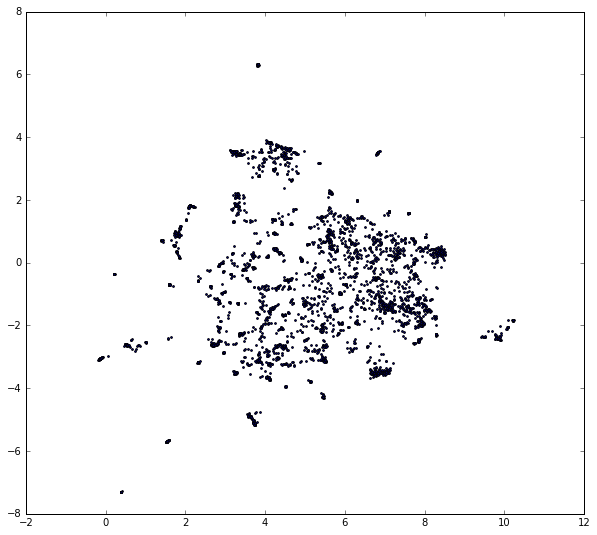

In [49]:
from umap.umap_ import UMAP
#使用UMAP算法将商品Embeddings的维数从100降到2，UMAP算法通常用于降维。
cluster_embedding = UMAP(n_neighbors=30, min_dist=0.0,n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')
plt.show()

In [56]:
#首先创建一个商品id和商品描述的字典，以便轻松地将商品的描述映射到其id，反之亦然。
products = train_df[["StockCode", "Description"]]
print(len(products))

# 去重
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")
print(len(products))

# 创建一个商品id和商品描述的字典
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

372187
3666


In [24]:
# 字典测试products_dict['84029E']
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

In [19]:
#定义了下面的函数。将一个商品的向量(n)作为输入，返回前6个相似的商品:
def similar_products(v, n = 6):
    # 为输入向量提取最相似的商品
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    # 提取相似产品的名称和相似度评分
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
    return new_ms        

In [25]:
similar_products(model['90019A'])

[('SILVER M.O.P ORBIT DROP EARRINGS', 0.7528426647186279),
 ('AMBER DROP EARRINGS W LONG BEADS', 0.7452982068061829),
 ('PINK SWEETHEART BRACELET', 0.7256171703338623),
 ('DROP DIAMANTE EARRINGS PURPLE', 0.7184370160102844),
 ('BLUE MURANO TWIST BRACELET', 0.7141450643539429),
 ('SILVER LARIAT BLACK STONE EARRINGS', 0.7084358334541321)]

In [28]:
#根据历史购买所有物品向量生成加权平均向量，然后计算这个平均向量的相似物品
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
    return np.mean(product_vec, axis=0)

In [29]:
len(purchases_val[0])

314

In [30]:
aggregate_vectors(purchases_val[0]).shape

(100,)

In [60]:
#根据用户的整个购买历史推荐了6款商品
similar_products(aggregate_vectors(purchases_val[0]))

[('PARTY BUNTING', 0.6701889038085938),
 ('JAM MAKING SET WITH JARS', 0.6581915616989136),
 ('CONDIMENT TRAY 4 BOWLS AND 4 SPOONS', 0.6517977118492126),
 ('ALARM CLOCK BAKELIKE RED ', 0.6450258493423462),
 ('SPOTTY BUNTING', 0.639930248260498),
 ('ROSES REGENCY TEACUP AND SAUCER ', 0.6370081305503845)]

In [61]:
similar_products(aggregate_vectors(purchases_val[0][-10:]))

[('HOT WATER BOTTLE TEA AND SYMPATHY', 0.6706283688545227),
 ('LOVE HOT WATER BOTTLE', 0.6663874387741089),
 ('SCOTTIE DOG HOT WATER BOTTLE', 0.6611403226852417),
 ('HOT WATER BOTTLE I AM SO POORLY', 0.6602486371994019),
 ('KNITTED UNION FLAG HOT WATER BOTTLE', 0.655508279800415),
 ('CHOCOLATE HOT WATER BOTTLE', 0.6538037061691284)]